In [ ]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import cv2 as cv

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import add, Flatten, Activation
from keras.models import Sequential
#from keras.optimizers import RMSprop
#from tensorflow.keras.utils  import plot_model, model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

### 导入数据集

In [ ]:
from sklearn.datasets import fetch_openml
x, y = fetch_openml('cifar10', version=1, return_X_y=True)
x = cifar10_dataset.images
y = cifar10_dataset.target
categories = np.array(np.unique(y))

### 数据预处理

In [ ]:
import cv2
down_width = 255
X=[]
for img in x:
    resized_img = cv.resize(img, (224, 224))
    #resized_img = cv.cvtColor(resized_img, cv.COLOR_GRAY2BGR)
    X.append(resized_img)


In [ ]:
StratifiedSplit = StratifiedShuffleSplit( test_size=0.3, random_state=0)
StratifiedSplit.get_n_splits(X, y)

for train_index, test_index in StratifiedSplit.split(X, y):
    x_train, X_test, y_train, y_test= X[train_index], X[test_index], y[train_index], y[test_index]

#归一化
X_train = x_train / 255

### 搭建模型

In [ ]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    x = Activation('relu')(x)
    return x


def Conv_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter[0], kernel_size=(1, 1), strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3, 3), padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1, 1), padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter[2], strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x


def creatcnn():
    #stage 0
    inpt = Input(shape=(224, 224, 3))
    x = ZeroPadding2D((3, 3))(inpt)
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #stage 1
    x = Conv_Block(x, nb_filter=[64, 64, 256], kernel_size=(3, 3), strides=(1, 1), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=[64, 64, 256], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[64, 64, 256], kernel_size=(3, 3))

    #stage 2
    x = Conv_Block(x, nb_filter=[128, 128, 512], kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=[128, 128, 512], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[128, 128, 512], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[128, 128, 512], kernel_size=(3, 3))
    #stage 3
    x = Conv_Block(x, nb_filter=[256, 256, 1024], kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=[256, 256, 1024], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[256, 256, 1024], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[256, 256, 1024], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[256, 256, 1024], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[256, 256, 1024], kernel_size=(3, 3))
    #stage 4
    x = Conv_Block(x, nb_filter=[512, 512, 2048], kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=[512, 512, 2048], kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=[512, 512, 2048], kernel_size=(3, 3))
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)

    #The sum of categories.
    x = Dense(19, activation='softmax')(x)#

    model = Model(inputs=inpt, outputs=x)
    return model

In [ ]:

lr_reduction=ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=10, 
    verbose=0, 
    mode='auto', 
    epsilon=0.0001, 
    cooldown=0, 
    min_lr=0
)
  
#当模型效果没有继续优化时提前停止
early_stopping_monitor = EarlyStopping(patience=2)

### 训练

In [ ]:
model = creatcnn()

#RMSProp优化器比AdaGrad效果好
model.compile(optimizer="RMSprop",loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
epoch = 64
batch_size = 64

In [ ]:
#生成一个batch_size大小的样本数据
datagen = ImageDataGenerator(
    rotation_range=5,  # randomly rotate images
    zoom_range = 0.05, # Randomly zoom image
)
datagen.fit(X_train)

In [ ]:
#读取数据集并处理
X_test = X_test/255

history = model.fit(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    epochs = epoch,
    validation_data = (X_test,y_test),
    verbose = 1,
    steps_per_epoch=X_train.shape[0] // batch_size, 
    callbacks=[lr_reduction]
)

Epoch 1/64
20/20 [==============================] - 39s 1s/step - loss: 4.5160 - sparse_categorical_accuracy: 0.1908 - val_loss: 12.5253 - val_sparse_categorical_accuracy: 0.0214 - lr: 0.0010
Epoch 2/64
20/20 [==============================] - 26s 1s/step - loss: 3.0917 - sparse_categorical_accuracy: 0.2512 - val_loss: 6.0387 - val_sparse_categorical_accuracy: 0.1266 - lr: 0.0010
Epoch 3/64
20/20 [==============================] - 30s 1s/step - loss: 2.9419 - sparse_categorical_accuracy: 0.2552 - val_loss: 475.2036 - val_sparse_categorical_accuracy: 0.2834 - lr: 0.0010
Epoch 4/64
20/20 [==============================] - 25s 1s/step - loss: 2.8792 - sparse_categorical_accuracy: 0.2657 - val_loss: 75.6447 - val_sparse_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 5/64
20/20 [==============================] - 25s 1s/step - loss: 2.6947 - sparse_categorical_accuracy: 0.2866 - val_loss: 66.2506 - val_sparse_categorical_accuracy: 0.2799 - lr: 0.0010
Epoch 6/64
20/20 [======================

### 可视化

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


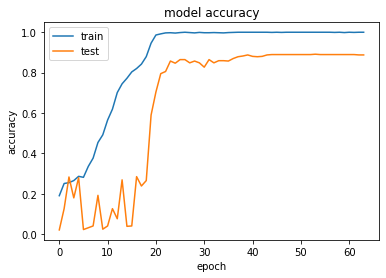

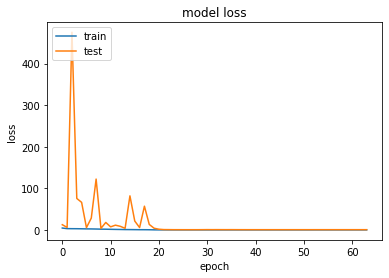

In [ ]:
print(history.history.keys())
# 画出每一层的accuracy值
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 画出每一层的Loss值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
